Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Forests of randomized trees

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col='rgiid')
df_main.columns

Index(['Unnamed: 0', 'x', 'y', 'Surge', 'Area', 'Slope', 'TermType', 'Name',
       'bed', 'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb',
       'width_centerline', 'Runoff'],
      dtype='object')

In [4]:
df_main.shape

(94234, 16)

In [5]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [6]:
df_main.drop(df_main[df_main['Surge']==9].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==1].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==2].index, inplace = True)
df = df_main.drop(columns = ['Unnamed: 0','x', 'y', 'ELA', 'beta', 'Name', 'Area'])
df.dropna(how='any', inplace=True)

In [7]:
df

,Surge,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy
rgiid,,,,,,,,,,,,
RGI60-07.00004,0,13.8,0,889.68555,25.314478,915.00000,1.392706,279.780932,1.100061,11.052210,6683.732353,0.581194
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.391001,295.980219,1.094416,9.567670,8640.744376,0.289903
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.389296,330.851846,1.088771,10.694908,9658.774620,0.888559
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.387591,342.886985,1.083127,11.083948,10010.124318,0.443691
RGI60-07.00004,0,13.8,0,881.31860,34.681380,916.00000,1.385886,336.403639,1.077530,9.699834,11010.043050,0.433976
...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,3,11.7,0,237.64468,50.380424,288.02512,-1.412920,278.553621,2.123592,5.529005,-10693.410549,0.389454
RGI60-07.01567,3,11.7,0,233.07228,46.717087,279.78937,-1.423469,256.755923,2.127417,5.495975,-9139.908345,0.017326
RGI60-07.01567,3,11.7,0,233.07228,46.717087,279.78937,-1.395654,238.477978,2.076787,5.104727,-8489.256385,0.180150


In [8]:
df_main.groupby('Surge').count()

,Unnamed: 0,x,y,Area,Slope,TermType,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff,WH,WHsin,dummy
Surge,,,,,,,,,,,,,,,,,,
0,68813,68813,68813,68813,68813,68813,48314,68813,68813,68813,68752,68752,68752,68707,68813,68707,68707,68813
3,10906,10906,10906,10906,10906,10906,10827,10906,10906,10906,10897,10897,10897,10905,10906,10905,10905,10906


In [9]:
df['Surge'] = df['Surge'].replace({3: 1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68675
1    10897
Name: label, dtype: int64

In [10]:
df[df['label']==1].shape[0]

10897

In [11]:
df.shape

(79572, 12)

### Resampled

In [12]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [13]:
df_downsampled.columns

Index(['label', 'Slope', 'TermType', 'bed', 'thickness', 'surface_elevation',
       'cmb', 'width_centerline', 'Runoff', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [14]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [15]:
train_labels.sum()/train_labels.shape[0]

0.5000327761389708

In [16]:
test_labels.sum()/test_labels.shape[0]

0.499923535708824

In [17]:
missing_data = df.isna()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

Slope
False    21794
Name: Slope, dtype: int64

TermType
False    21794
Name: TermType, dtype: int64

bed
False    21794
Name: bed, dtype: int64

thickness
False    21794
Name: thickness, dtype: int64

surface_elevation
False    21794
Name: surface_elevation, dtype: int64

cmb
False    21794
Name: cmb, dtype: int64

width_centerline
False    21794
Name: width_centerline, dtype: int64

Runoff
False    21794
Name: Runoff, dtype: int64

WH
False    21794
Name: WH, dtype: int64

WHsin
False    21794
Name: WHsin, dtype: int64

dummy
False    21794
Name: dummy, dtype: int64



In [18]:
4081/81683

0.04996143628417174

In [19]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'cmb',
 'width_centerline',
 'Runoff',
 'WH',
 'WHsin',
 'dummy']

In [20]:
train.shape

(15255, 11)

In [21]:
train_labels.shape

(15255,)

In [22]:
test.shape

(6539, 11)

### Evaluate the decision tree

In [23]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'm', label = 'model')
    plt.text(s = 'AUC = ' + str(round(roc_auc_score(train_labels, train_probs),2))
    , x=0.6, y=0.0, fontsize=15
)
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

# Gradient boosting

In [33]:
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [34]:
# dmatrix_train = xgboost.DMatrix(train[train.columns[1:]], label=train_labels)
# dmatrix_test = xgboost.DMatrix(test[test.columns[1:]], label=test_labels)

dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [26]:
train_labels

array([1, 0, 0, ..., 0, 0, 1])

In [27]:
test_labels

array([1, 0, 0, ..., 0, 0, 0])

In [28]:
trainprob = train.copy()
trainprob['y'] = train_labels

trainprob.corr()

,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy,y
Slope,1.000000,-0.268806,0.436993,-0.531408,0.264753,0.202393,-0.355296,-0.180692,-0.091803,0.112600,0.005098,-0.407064
TermType,-0.268806,1.000000,-0.316771,0.376568,-0.195513,-0.129612,0.226940,0.187502,0.033846,-0.131927,0.003860,0.307612
bed,0.436993,-0.316771,1.000000,-0.442591,0.927752,0.750252,-0.205606,-0.648754,0.034408,0.080649,0.003624,-0.287526
thickness,-0.531408,0.376568,-0.442591,1.000000,-0.075959,-0.030000,0.365110,0.033617,-0.047945,-0.235068,0.007142,0.325232
surface_elevation,0.264753,-0.195513,0.927752,-0.075959,1.000000,0.821757,-0.076672,-0.707391,0.018306,-0.008153,0.007003,-0.184359
cmb,0.202393,-0.129612,0.750252,-0.030000,0.821757,1.000000,0.024266,-0.820261,0.049439,-0.097226,0.002364,-0.171054
width_centerline,-0.355296,0.226940,-0.205606,0.365110,-0.076672,0.024266,1.000000,-0.048355,0.645546,-0.594876,-0.008005,0.194559
Runoff,-0.180692,0.187502,-0.648754,0.033617,-0.707391,-0.820261,-0.048355,1.000000,-0.051397,0.125854,-0.002571,0.207907
WH,-0.091803,0.033846,0.034408,-0.047945,0.018306,0.049439,0.645546,-0.051397,1.000000,-0.265646,-0.004128,0.047362
WHsin,0.112600,-0.131927,0.080649,-0.235068,-0.008153,-0.097226,-0.594876,0.125854,-0.265646,1.000000,0.005710,-0.067655


In [40]:
# trainprob.Area.hist(bins=100)

In [41]:
# trainprob[trainprob.y==0].Area.describe()

In [42]:
# trainprob[trainprob.y==1].Area.describe()

In [35]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,10)
    for min_child_weight in range(1,100, 10)
]

In [31]:
gridsearch_params

[(1, 1),
 (1, 11),
 (1, 21),
 (1, 31),
 (1, 41),
 (1, 51),
 (1, 61),
 (1, 71),
 (1, 81),
 (1, 91),
 (2, 1),
 (2, 11),
 (2, 21),
 (2, 31),
 (2, 41),
 (2, 51),
 (2, 61),
 (2, 71),
 (2, 81),
 (2, 91),
 (3, 1),
 (3, 11),
 (3, 21),
 (3, 31),
 (3, 41),
 (3, 51),
 (3, 61),
 (3, 71),
 (3, 81),
 (3, 91),
 (4, 1),
 (4, 11),
 (4, 21),
 (4, 31),
 (4, 41),
 (4, 51),
 (4, 61),
 (4, 71),
 (4, 81),
 (4, 91),
 (5, 1),
 (5, 11),
 (5, 21),
 (5, 31),
 (5, 41),
 (5, 51),
 (5, 61),
 (5, 71),
 (5, 81),
 (5, 91),
 (6, 1),
 (6, 11),
 (6, 21),
 (6, 31),
 (6, 41),
 (6, 51),
 (6, 61),
 (6, 71),
 (6, 81),
 (6, 91),
 (7, 1),
 (7, 11),
 (7, 21),
 (7, 31),
 (7, 41),
 (7, 51),
 (7, 61),
 (7, 71),
 (7, 81),
 (7, 91),
 (8, 1),
 (8, 11),
 (8, 21),
 (8, 31),
 (8, 41),
 (8, 51),
 (8, 61),
 (8, 71),
 (8, 81),
 (8, 91),
 (9, 1),
 (9, 11),
 (9, 21),
 (9, 31),
 (9, 41),
 (9, 51),
 (9, 61),
 (9, 71),
 (9, 81),
 (9, 91)]

In [36]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [39]:
# Define initial best params and MAE
num_boost_round = 999
min_mae = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dmatrix_train,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))


CV with max_depth=1, min_child_weight=1
[17:25:49] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:49] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:49] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:49] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:49] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.3172466 for 995 rounds
CV with max_depth=1, min_child_weight=11
[17:29:52] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:29:52] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:29:52] WARNING: ../src/objective/regression_obj.cu:1

In [40]:
params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':9, 'scale_pos_weight':0.5}

xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

[15:12:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [41]:
predictions_xgboost = xgb.predict(dmatrix_test)
# pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost})
# pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_xgboost_centerline_resample_area.csv')

Text(0.6, 0.0, 'AUC = 1.0')

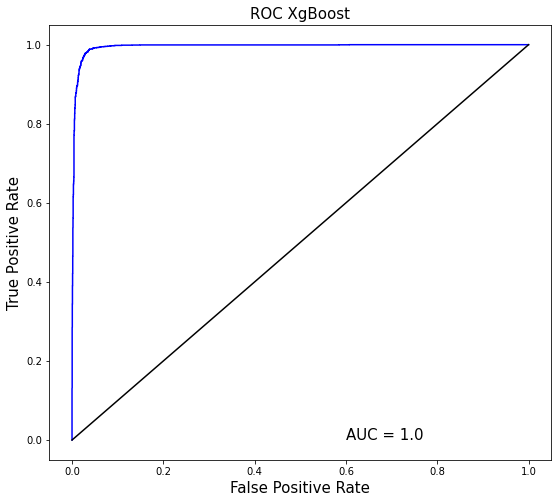

In [42]:
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

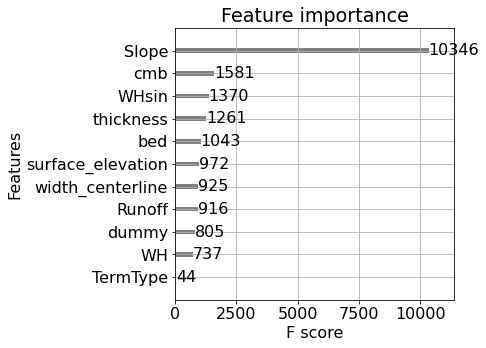

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax, color='grey')

In [47]:
average_precision_xgboost = average_precision_score(test_labels, predictions_xgboost)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_xgboost))

Average precision-recall score: 0.92


In [48]:
test_labels.dtype

dtype('int64')

Confusion matrix, without normalization
[[44  5]
 [11 38]]


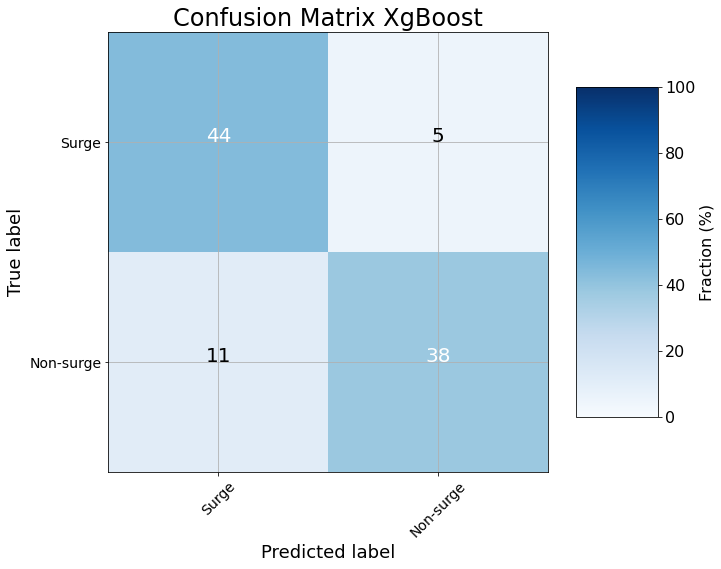

In [49]:
# confusion_matrix(test_labels, predictions.round())
cm_xgboost = confusion_matrix(test_labels, predictions_xgboost.round())
plot_confusion_matrix((cm_xgboost/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix XgBoost', cmap='Blues')

Theory: https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148

Example: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

# Logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
logreg = LogisticRegression()
logreg.fit(train, train_labels)

LogisticRegression()

In [52]:
predictions_LR = logreg.predict(test)
probs_LR = logreg.predict_proba(test)[:, 1]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test, test_labels)))

Accuracy of logistic regression classifier on test set: 0.69


In [53]:
test_labels.sum()

3269

In [54]:
pd.DataFrame({'true':test_labels, 'predictions':predictions_LR, 'prob':probs_LR}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_LR_centerline_resample_area.csv')

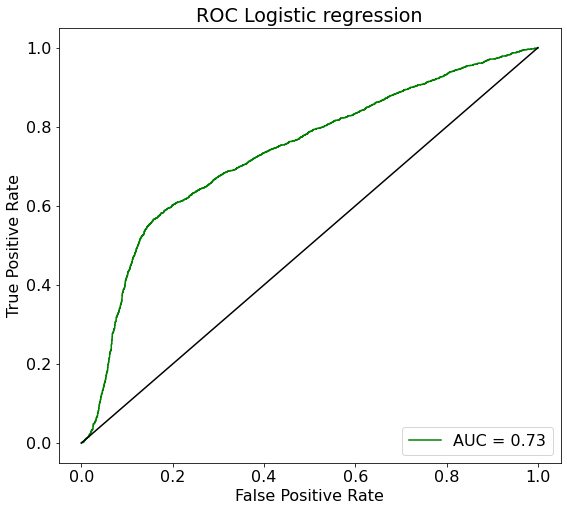

In [55]:
logit_roc_auc = roc_auc_score(test_labels, logreg.predict_proba(test)[:,1])
fpr, tpr, thresholds = roc_curve(test_labels, logreg.predict_proba(test)[:,1])
plt.figure(figsize=(9, 8))
plt.plot(fpr, tpr, 'g', label='AUC = %0.2f' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k')
# # plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic regression')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

<function confusion_matrix at 0x7ff3ef8cdaf0>
Confusion matrix, without normalization
[[35 14]
 [16 33]]


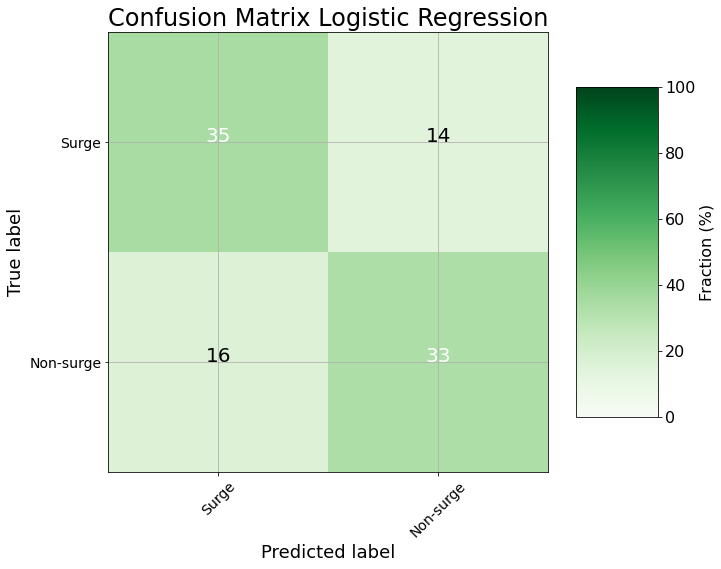

In [56]:
from sklearn.metrics import confusion_matrix
cm_LR = confusion_matrix(test_labels, predictions_LR)
print(confusion_matrix)
plot_confusion_matrix((cm_LR/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix Logistic Regression', cmap='Greens')

In [57]:
average_precision_LR = average_precision_score(test_labels, predictions_LR)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_LR))

Average precision-recall score: 0.63


Text(0.5, 1.0, '2-class Precision-Recall curve RF: AP=0.63')

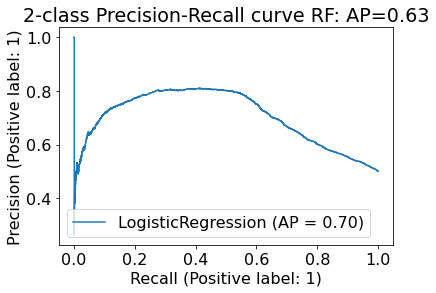

In [58]:
disp_lr = plot_precision_recall_curve(logreg, test, test_labels)
disp_lr.ax_.set_title('2-class Precision-Recall curve RF: '
                   'AP={0:0.2f}'.format(average_precision_LR))